In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime
from datetime import date

pd.options.display.max_columns = 40

## Hack for Heat #7: Heat complaints over time

In the last post, I plotted how the number of complaints differd by borough over time. This time around, I'm going to revisit this process, but this time focusing on heating complaints only (this is Heat Seek, after all).

## Loading data:

In [2]:
connection = psycopg2.connect('dbname = threeoneone user=threeoneoneadmin password=threeoneoneadmin')
cursor = connection.cursor()

In [3]:
cursor.execute('''SELECT DISTINCT complainttype FROM service;''')
complainttypes = cursor.fetchall()

In [4]:
cursor.execute('''SELECT createddate, borough, complainttype FROM service;''')
borodata = cursor.fetchall()

In [5]:
borodata = pd.DataFrame(borodata)

In [6]:
borodata.head()

,0,1,2
0,2011-04-15,MANHATTAN,Street Condition
1,2011-04-15,MANHATTAN,Street Condition
2,2011-04-15,MANHATTAN,Street Condition
3,2011-04-15,MANHATTAN,Street Condition
4,2011-04-14,QUEENS,Street Condition


In [7]:
borodata.columns = ['Date', 'Boro', 'Comptype']

In [8]:
heatdata = borodata.loc[(borodata['Comptype'] == 'HEATING') | (borodata['Comptype'] == 'HEAT/HOT WATER')]

I removed entires earlier than 2011 because there are data quality issues (substantially fewer cases):

In [9]:
heatdata = heatdata.loc[heatdata['Date'] > date(2011,3,1)]

## Heat complaints by borough:

In [10]:
len(heatdata)

1092048

There were about a million heating complaints over the 3+ years we have data for.

In [11]:
heatbydate = heatdata.groupby(by='Boro').count()

In [12]:
heatbydate

,Date,Comptype
Boro,,
BRONX,354335,354335
BROOKLYN,334574,334574
MANHATTAN,250296,250296
QUEENS,138477,138477
STATEN ISLAND,10601,10601
Unspecified,3765,3765


### Per capita:

Again, let's look at how many heat complaints each boro generates per person:

In [13]:
boropop = {
    'MANHATTAN': 1636268,
    'BRONX': 1438159,
    'BROOKLYN': 2621793,
    'QUEENS': 2321580,
    'STATEN ISLAND': 473279,
    }

In [14]:
heatbydate['Pop'] = [boropop.get(x) for x in heatbydate.index]

In [15]:
heatbydate['CompPerCap'] = heatbydate['Date']/heatbydate['Pop']

In [16]:
heatbydate

,Date,Comptype,Pop,CompPerCap
Boro,,,,
BRONX,354335,354335,1438159.0,0.246381
BROOKLYN,334574,334574,2621793.0,0.127613
MANHATTAN,250296,250296,1636268.0,0.152968
QUEENS,138477,138477,2321580.0,0.059648
STATEN ISLAND,10601,10601,473279.0,0.022399
Unspecified,3765,3765,NaN,NaN


## Complaints by borough over months

First, let's recreate the graph from before:

In [17]:
heatdata['Year'] = [x.year for x in heatdata['Date']]
heatdata['Month'] = [x.month for x in heatdata['Date']]
heatdata['Day'] = [x.day for x in heatdata['Date']]

In [18]:
heatdata.head()

,Date,Boro,Comptype,Year,Month,Day
58,2015-10-17,BROOKLYN,HEAT/HOT WATER,2015,10,17
728,2011-04-16,MANHATTAN,HEATING,2011,4,16
1026,2011-04-16,BROOKLYN,HEATING,2011,4,16
1418,2015-10-17,MANHATTAN,HEAT/HOT WATER,2015,10,17
1624,2011-04-15,MANHATTAN,HEATING,2011,4,15


We remove data where it was unspecified what the boro was

In [19]:
heatdata = heatdata.loc[heatdata['Boro'] != 'Unspecified']

In [20]:
heatplotdata = heatdata.groupby(by=['Boro', 'Year','Month']).count()
heatplotdata

Date  Comptype    Day
Boro          Year Month                        
BRONX         2011 3       5101      5101   5101
                   4       3339      3339   3339
                   5       1217      1217   1217
                   6        562       562    562
                   7        564       564    564
                   8        482       482    482
                   9        674       674    674
                   10      5954      5954   5954
                   11      7393      7393   7393
                   12     10536     10536  10536
              2012 1      12655     12655  12655
                   2       7146      7146   7146
                   3       5049      5049   5049
                   4       3336      3336   3336
                   5       1214      1214   1214
                   6        672       672    672
                   7        688       688    688
                   8        711       711    711
                   9        675       675    675
                   10      3488      3488   3488
                   11     11853     11853  11853
                   12      9365      9365   9365
              2013 1      13580     13580  13580
                   2      10037     10037  10037
                   3       6794      6794   6794
                   4       3706      3706   3706
                   5       1545      1545   1545
                   6        861       861    861
                   7        605       605    605
                   8        593       593    593
...                         ...       ...    ...
STATEN ISLAND 2013 12       261       261    261
              2014 1        491       491    491
                   2        199       199    199
                   3        206       206    206
                   4        112       112    112
                   5         70        70     70
                   6         35        35     35
                   7         32        32     32
                   8         31        31     31
                   9         36        36     36
                   10       216       216    216
                   11       405       405    405
                   12       246       246    246
              2015 1        402       402    402
                   2        523       523    523
                   3        216       216    216
                   4         91        91     91
                   5         58        58     58
                   6         31        31     31
                   7         24        24     24
                   8         31        31     31
                   9         31        31     31
                   10       261       261    261
                   11       250       250    250
                   12       230       230    230
              2016 1        480       480    480
                   2        327       327    327
                   3        133       133    133
                   4        110       110    110
                   5         79        79     79

[315 rows x 3 columns]

In [21]:
boros = heatbydate.index
borodict = {x:[] for x in boros}
borodict.pop('Unspecified')

for boro in borodict:
    borodict[boro] = list(heatplotdata.xs(boro).Date)

In [22]:
plotdata = np.zeros(len(borodict['BROOKLYN']))
for boro in sorted(borodict.keys()):
    plotdata = np.row_stack((plotdata, borodict[boro]))

In [23]:
plotdata = np.delete(plotdata, (0), axis=0)

In [25]:
from matplotlib import patches as mpatches

x = np.arange(len(plotdata[0]))

#crude xlabels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years = ['2011', '2012', '2013', '2014', '2015', '2016']
xlabels = []
for year in years:
    for month in months:
        xlabels.append("{0} {1}".format(month,year))

xlabels = xlabels[2:-7] #start from march 2011, end may2016

## A non-normalized plot:

The plot below is of raw complaint numbers, and is what we might expect: complaints about eat matter the most during the heating season!

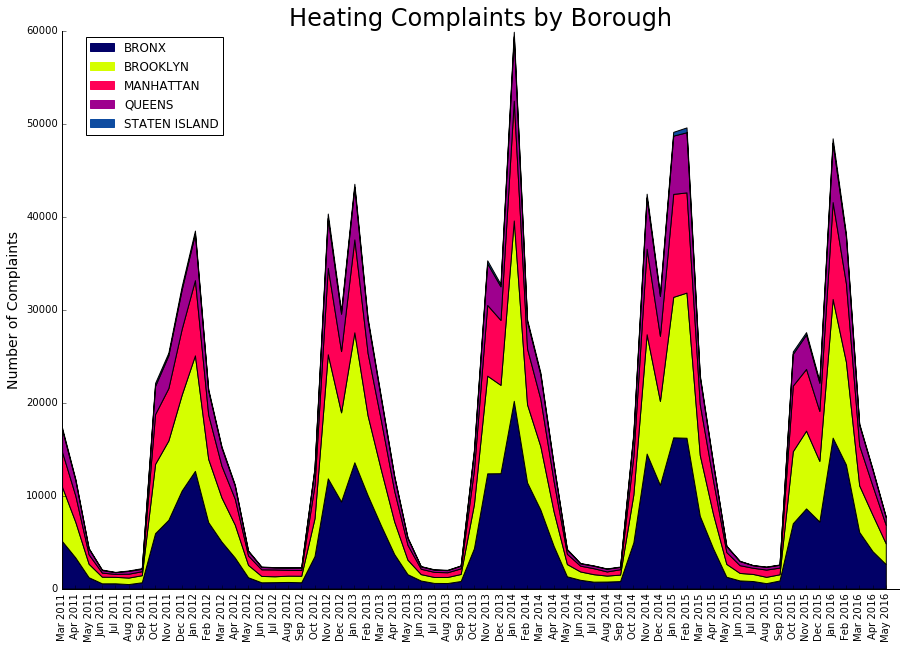

In [26]:
plotcolors = [(1,0,103),(213,255,0),(255,0,86),(158,0,142),(14,76,161),(255,229,2),(0,95,57),\
            (0,255,0),(149,0,58),(255,147,126),(164,36,0),(0,21,68),(145,208,203),(98,14,0)]

#rescaling rgb from 0-255 to 0 to 1
plotcolors = [(color[0]/float(255),color[1]/float(255),color[2]/float(255)) for color in plotcolors]
legendcolors = [mpatches.Patch(color = color) for color in plotcolors]

plt.figure(figsize = (15,10));
plt.stackplot(x,plotdata, colors = plotcolors);
plt.xticks(x,xlabels,rotation=90);
plt.xlim(0,len(xlabels))
plt.legend(legendcolors,sorted(borodict.keys()), bbox_to_anchor=(0.2, 1));
plt.title('Heating Complaints by Borough', size = 24)
plt.ylabel('Number of Complaints',size = 14)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

## Normalizing data:

Next, we're going to normalize these data. This allows us to better visualize if the proportion of heating complaints changed by borough, over time (e.g., did one borough generate more/less complaints vs. others over time?).

What we want to do is divide each of the 5 rows by the total number of complaints by that column (the month)

In [27]:
totalcounts = heatdata.groupby(by=['Year', 'Month']).count().Date.values

In [40]:
boros = heatbydate.index
normdict = {x:[] for x in boros}
normdict.pop('Unspecified')

for boro in normdict:
    for i in range(0,len(plotdata[1])): # for all the values in each row
        normp = float(borodict[boro][i])/float(totalcounts[i])
        normdict[boro].append(normp*100)

In [41]:
normplotdata = np.zeros(len(borodict['BROOKLYN']))
for boro in sorted(normdict.keys()):
    normplotdata = np.row_stack((normplotdata, normdict[boro]))

In [42]:
normplotdata = np.delete(normplotdata,(0),axis = 0)

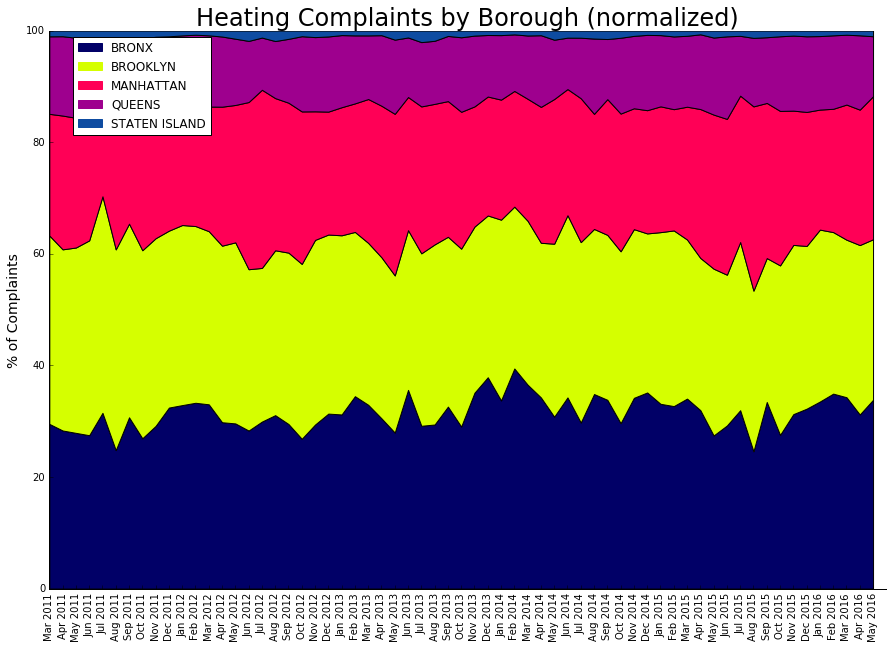

In [44]:
plotcolors = [(1,0,103),(213,255,0),(255,0,86),(158,0,142),(14,76,161),(255,229,2),(0,95,57),\
            (0,255,0),(149,0,58),(255,147,126),(164,36,0),(0,21,68),(145,208,203),(98,14,0)]

#rescaling rgb from 0-255 to 0 to 1
plotcolors = [(color[0]/float(255),color[1]/float(255),color[2]/float(255)) for color in plotcolors]
legendcolors = [mpatches.Patch(color = color) for color in plotcolors]

plt.figure(figsize = (15,10));
plt.stackplot(x,normplotdata, colors = plotcolors);
plt.xticks(x,xlabels,rotation=90);
plt.xlim(0,len(xlabels))
plt.ylim(0,100)
plt.legend(legendcolors,sorted(normdict.keys()), bbox_to_anchor=(0.2, 1));
plt.title('Heating Complaints by Borough (normalized)', size = 24)
plt.ylabel('% of Complaints',size = 14)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

Overall, it looks like heating complaints were pretty consistent by borough. In the next post, I'm going to take a look at one way of addressing the afore-mentioned censoring problems.